In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pwd

'/content'

In [3]:
cd drive/MyDrive/metis/class_projects/waste_classification/data

/content/drive/MyDrive/metis/class_projects/waste_classification/data


In [4]:
# import libraries
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from os import path
from glob import glob
from tqdm import tqdm

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow import keras 

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import InputLayer, MaxPooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
#     plt.savefig('../images/model_accuracy.png')
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Validation Binary Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig('../images/model_loss.png')
    plt.show()

In [6]:
# create directory paths for images (from dataset)
base_dir = './COMPLETE_DATASET'
train_dir = path.join(base_dir, 'TRAIN')
test_dir = path.join(base_dir, 'TEST')

print(train_dir)
print(test_dir)

./COMPLETE_DATASET/TRAIN
./COMPLETE_DATASET/TEST


# EDA

In [7]:
# .jpg files of organic images from train data
train_org = glob(path.join(train_dir, 'O', '*.jpg'))
print('Number of organic (train) images: ', len(train_org))

Number of organic (train) images:  12565


In [8]:
# .jpg files of recyclable images from train data
train_re = glob(path.join(train_dir, 'R', '*.jpg'))
print('Number of recyclable (train) images: ', len(train_re))

Number of recyclable (train) images:  9999


In [9]:
# .jpg files of organic images from train data
test_org = glob(path.join(test_dir, 'O', '*.jpg'))
print('Number of organic (test) images: ', len(test_org))

Number of organic (test) images:  1401


In [10]:
# .jpg files of organic images from train data
test_re = glob(path.join(test_dir, 'R', '*.jpg'))
print('Number of recyclable (test) images: ', len(test_re))

Number of recyclable (test) images:  1112


In [11]:
print('Number of total (train + test) images: ', len(train_org)+len(train_re)+len(test_org)+len(test_re))
print('Number of train (organic + recyclable) images: ', len(train_org)+len(train_re))
print('Number of test (organic + recyclable) images: ', len(test_org)+len(test_re))

Number of total (train + test) images:  25077
Number of train (organic + recyclable) images:  22564
Number of test (organic + recyclable) images:  2513


In [12]:
x_data = []
y_data = []

for folder in glob(path.join(train_dir, '*')):
    for file in tqdm(glob(path.join(folder, '*.jpg'))):
        img_array = plt.imread(file)
        x_data.append(img_array)
        y_data.append(folder.split('/')[-1])

train_data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████| 12565/12565 [00:27<00:00, 459.30it/s]


In [14]:
train_data.shape

(22564, 2)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


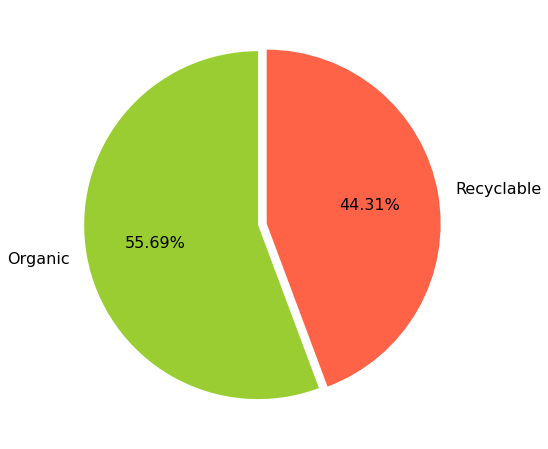

In [15]:
# pie chart of classes
plt.figure(figsize=(8,8))
plt.pie(train_data.label.value_counts(), 
        explode=[0.025,0.025],
        colors=['yellowgreen', 'tomato'],
        labels=['Organic', 'Recyclable'],
        autopct='%.2f%%',
        startangle=90,
        textprops={'fontsize':16})
# plt.savefig('../images/class_balance.png')
plt.show()

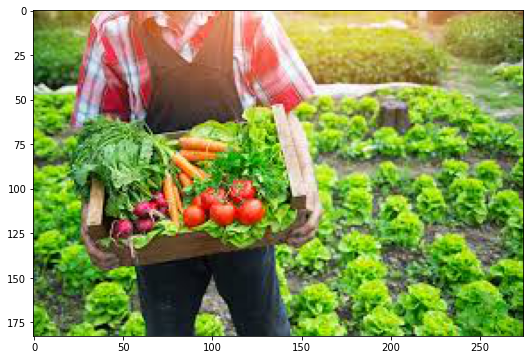

In [21]:
# read and display organic image
plt.imshow(plt.imread(train_org[20]))

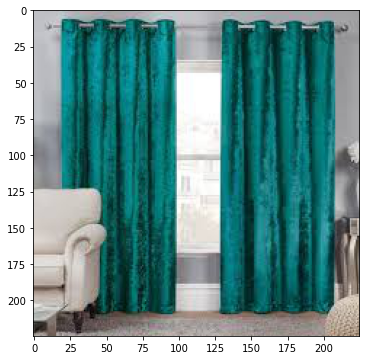

In [22]:
# read and display recyclable images
plt.imshow(plt.imread(train_re[30]))

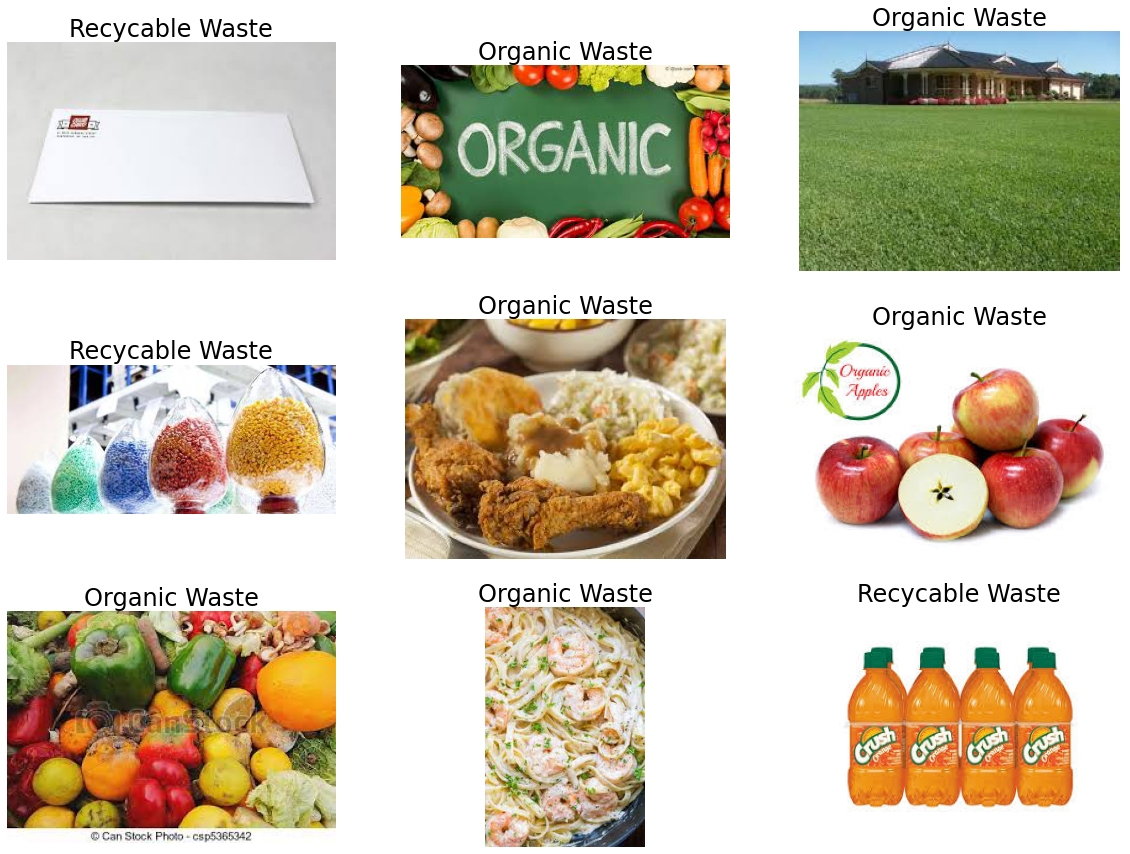

In [23]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%12)+1)
    index=np.random.randint(22000)
    
    plt.imshow(train_data.image[index])
    plt.axis('off')
    
    if train_data.label[index] == 'O':
        plt.title('Organic Waste', fontdict={'size':24})
    else:
        plt.title('Recycable Waste', fontdict={'size':24})

# plt.savefig('../images/images_from_dataset.png')     
plt.show()

In [24]:
# return shape for first 10 organic images
for img in train_org[0:10]:
    print((plt.imread(img)).shape)

(192, 262, 3)
(183, 275, 3)
(183, 275, 3)
(282, 179, 3)
(225, 224, 3)
(172, 292, 3)
(183, 275, 3)
(194, 259, 3)
(251, 201, 3)
(225, 225, 3)


In [25]:
# return shape for first 10 recyclable images
for img in train_re[0:10]:
    print((plt.imread(img)).shape)

(225, 225, 3)
(225, 225, 3)
(225, 225, 3)
(194, 259, 3)
(225, 225, 3)
(225, 225, 3)
(194, 259, 3)
(168, 300, 3)
(256, 197, 3)
(225, 225, 3)


# IMAGE PREPROCESSING

In [26]:
img_height = 256
img_width = 256
batch_size = 32

In [27]:
# image scaling
datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

In [28]:
# initialize train, testing generator
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [29]:
train_generator.class_indices

{'O': 0, 'R': 1}

In [30]:
# iterate batches -> store the data in x_train, y_train
train_generator.reset()
x_train, y_train = next(train_generator)

#1st batch is already fetched before the for loop
for i in tqdm(range(int(len(train_generator)/32)-1)): 
    img, label = next(train_generator)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|██████████| 21/21 [00:07<00:00,  2.80it/s]

(704, 256, 256, 3) (704,)


In [31]:
# iterate batches -> store the data in x_test, y_test
test_generator.reset()
x_test, y_test = next(test_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(test_generator)/32)-1)): 
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(x_test.shape, y_test.shape)

100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

(64, 256, 256, 3) (64,)


# NON DEEP LEARNING MODEL

In [32]:
print(x_train.ndim)
print(x_test.ndim)

4
4


In [33]:
# reshape x_train values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_train.shape
x_train_2d = x_train.reshape((nsamples,nx*ny*nrgb))

In [34]:
# reshape x_test values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_test.shape
x_test_2d = x_test.reshape((nsamples,nx*ny*nrgb))

## RANDOM FOREST CLASSIFIER

In [35]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_2d)
x_train_2pc = pca.transform(x_train_2d)

# reduce test data dimensions using PCA
pca.fit(x_test_2d)
x_test_2pc = pca.transform(x_test_2d)

print(np.shape(x_train_2pc))
print(np.shape(x_test_2pc))

(704, 2)
(64, 2)


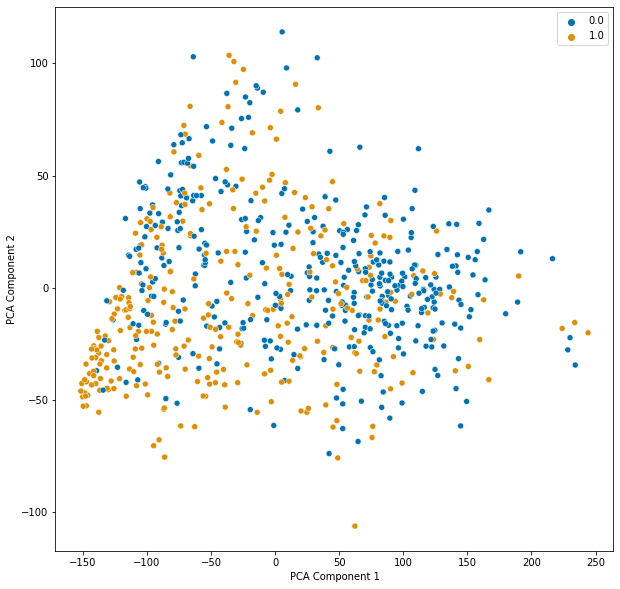

In [36]:
# plot PCA 
plt.figure(figsize=(10,10))

sns.scatterplot(x=x_train_2pc[:, 0], y=x_train_2pc[:, 1],
                hue=y_train,
                palette=sns.color_palette("colorblind", 2))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# plt.savefig('../images/pca_plot.png')
plt.show()

In [37]:
# instantiate and fit non deep learning model
rf = RandomForestClassifier()
rf.fit(x_train_2pc,y_train)

RandomForestClassifier()

In [38]:
# predict target values
rf_y_pred = rf.predict(x_test_2pc)
rf_y_pred[0:10]

array([0., 1., 1., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)

In [39]:
# evaluate
print(f"Random Forest MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Random Forest MAE: 0.7656
Random Forest MSE: 0.7656
Random Forest Accuracy: 0.2344


In [40]:
# loss score for random forest?

## LOGISTIC REGRESSION

In [41]:
# standardized values for logistic regression
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train_2d)
x_test_scaled = sc.transform(x_test_2d)

In [42]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_scaled)
x_train_scaled_2pc = pca.transform(x_train_scaled)

# reduce test data dimensions using PCA
pca.fit(x_test_scaled)
x_test_scaled_2pc = pca.transform(x_test_scaled)

print(np.shape(x_train_scaled_2pc))
print(np.shape(x_test_scaled_2pc))

(704, 2)
(64, 2)


In [43]:
# instantiate and fit logistic regression
lr = LogisticRegression()
lr.fit(x_train_scaled_2pc, y_train)

LogisticRegression()

In [44]:
# predict target values
lr_y_pred = lr.predict(x_test_scaled_2pc)
lr_y_pred[0:10]

array([0., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)

In [45]:
# evaluate metrics
print(f"Logistic Regression MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Logistic Regression MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Logistic Regression Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Logistic Regression MAE: 0.7656
Logistic Regression MSE: 0.7656
Logistic Regression Accuracy: 0.2344


In [46]:
# loss score for logistic regression?

# ADDITIONAL PREPROCESSING

In [47]:
# image scaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [48]:
# initialize train, validation, testing generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42)

valid_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [49]:
earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0.005,
                              patience=5,
                              mode='max',
                              verbose=1)

checkpoint = ModelCheckpoint(filepath='./checkpoint/',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

callbacks = [earlystopping, checkpoint]

# SIMPLE NEURAL NET

In [50]:
model1 = Sequential()

model1.add(Flatten(input_shape=(256,256,3)))
model1.add(Dense(units=20, activation='relu'))
model1.add(Dense(units=10, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

model1.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 20)                3932180   
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,932,401
Trainable params: 3,932,401
Non-trainable params: 0
_________________________________________________________________


In [51]:
simple_neural_net = model1.fit(train_generator,
                               epochs=20,
                               validation_data=valid_generator,
                               callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 1.1439 - accuracy: 0.7127
Epoch 1: val_accuracy improved from -inf to 0.78258, saving model to ./checkpoint/
565/565 [==============================] - 63s 111ms/step - loss: 1.1439 - accuracy: 0.7127 - val_loss: 0.7576 - val_accuracy: 0.7826
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 1.0262 - accuracy: 0.7272
Epoch 2: val_accuracy did not improve from 0.78258
565/565 [==============================] - 58s 103ms/step - loss: 1.0262 - accuracy: 0.7272 - val_loss: 0.6597 - val_accuracy: 0.7730
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.8450 - accuracy: 0.7419
Epoch 3: val_accuracy did not improve from 0.78258
565/565 [==============================] - 57s 101ms/step - loss: 0.8450 - accuracy: 0.7419 - val_loss: 1.7881 - val_accuracy: 0.5973
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.7605
Epoch 4: val_accuracy did not

In [52]:
# evaluate model
neural_net_loss, neural_net_accuracy = model1.evaluate(test_generator)
print(f"Test Accuracy: {neural_net_accuracy:.4f}")
print(f"Test Loss: {neural_net_loss:.4f}")

79/79 [==============================] - 7s 84ms/step - loss: 0.3654 - accuracy: 0.8671
Test Accuracy: 0.8671
Test Loss: 0.3654


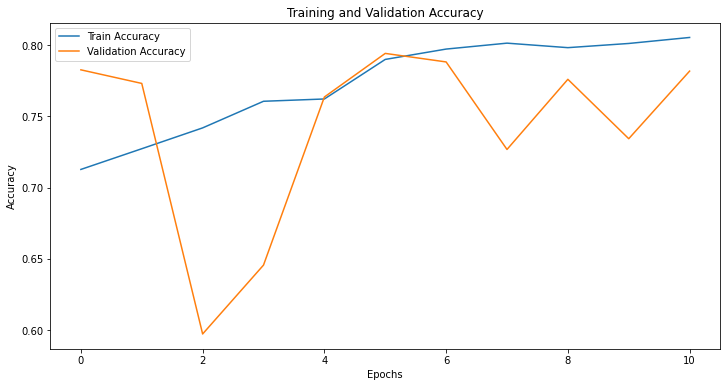

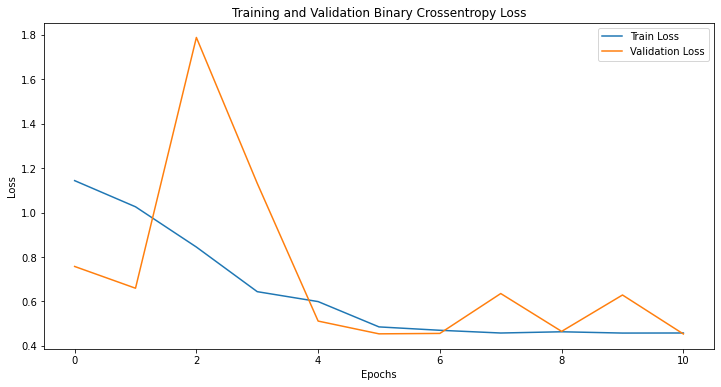

In [53]:
# plot model performance
model_performance_plot(simple_neural_net)

# SIMPLE CNN

In [54]:
model2 = Sequential()

model2.add(InputLayer(input_shape=(256,256,3)))

model2.add(Conv2D(filters=16,kernel_size=3,activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
    
model2.add(Flatten())
    
model2.add(Dense(16, activation='relu'))
    
model2.add(Dense(1, activation='sigmoid'))
    
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 258064)            0         
                                                                 
 dense_3 (Dense)             (None, 16)                4129040   
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,129,505
Trainable params: 4,129,505
Non-trainable params: 0
____________________________________________

In [55]:
simple_cnn = model2.fit(train_generator,
                        epochs=20,
                        validation_data=valid_generator,
                        callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.8036
Epoch 1: val_accuracy did not improve from 0.79410
565/565 [==============================] - 66s 113ms/step - loss: 0.5383 - accuracy: 0.8036 - val_loss: 0.4529 - val_accuracy: 0.7781
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8614
Epoch 2: val_accuracy did not improve from 0.79410
565/565 [==============================] - 61s 108ms/step - loss: 0.3442 - accuracy: 0.8614 - val_loss: 0.5315 - val_accuracy: 0.7715
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9018
Epoch 3: val_accuracy did not improve from 0.79410
565/565 [==============================] - 59s 104ms/step - loss: 0.2476 - accuracy: 0.9018 - val_loss: 0.5116 - val_accuracy: 0.7702
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9342
Epoch 4: val_accuracy did not improve from 0.79410
565/565 [=

In [56]:
# evaluate model
simple_loss, simple_accuracy = model2.evaluate(test_generator)
print(f"Test Accuracy: {simple_accuracy:.4f}")
print(f"Test Loss: {simple_loss:.4f}")

79/79 [==============================] - 7s 83ms/step - loss: 1.0893 - accuracy: 0.8090
Test Accuracy: 0.8090
Test Loss: 1.0893


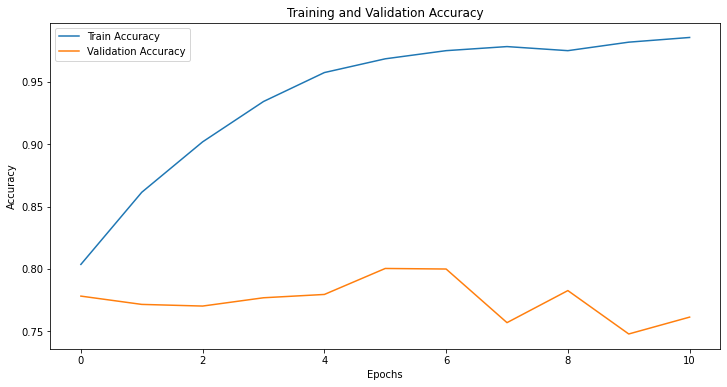

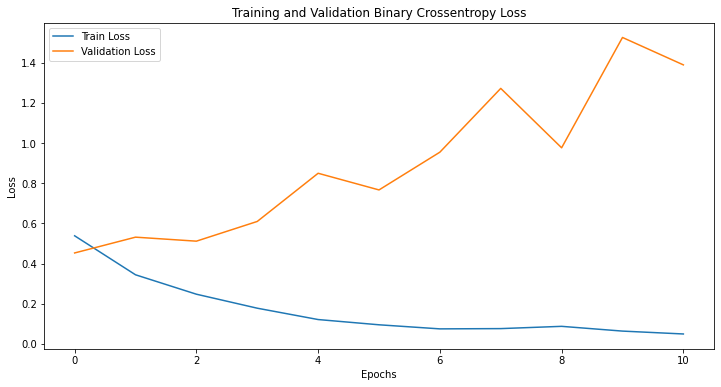

In [57]:
model_performance_plot(simple_cnn)

# COMPLEX CNN

In [58]:
model3 = Sequential()

model3.add(InputLayer(input_shape=(256,256,3)))

model3.add(Conv2D(filters=16, kernel_size=3, padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(filters=32, kernel_size=3, padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

# model3.add(Conv2D(filters=64, kernel_size=3, padding='same'))
# model3.add(BatchNormalization())
# model3.add(Activation('relu'))
# model3.add(MaxPooling2D())

model3.add(Flatten())

# model3.add(Dense(64))
# model3.add(BatchNormalization())
# model3.add(Activation('relu'))
# model3.add(Dropout(0.5))

model3.add(Dense(32))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(16))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(1))
model3.add(BatchNormalization())
model3.add(Activation('sigmoid'))

model3.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)    

In [59]:
complex_cnn = model3.fit(train_generator,
                        epochs=20,
                        validation_data=valid_generator,
                        callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7713
Epoch 1: val_accuracy improved from 0.80031 to 0.82558, saving model to ./checkpoint/
565/565 [==============================] - 65s 111ms/step - loss: 0.5170 - accuracy: 0.7713 - val_loss: 0.4734 - val_accuracy: 0.8256
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8164
Epoch 2: val_accuracy did not improve from 0.82558
565/565 [==============================] - 61s 107ms/step - loss: 0.4458 - accuracy: 0.8164 - val_loss: 0.4451 - val_accuracy: 0.7939
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8346
Epoch 3: val_accuracy improved from 0.82558 to 0.82602, saving model to ./checkpoint/
565/565 [==============================] - 64s 113ms/step - loss: 0.4075 - accuracy: 0.8346 - val_loss: 0.3891 - val_accuracy: 0.8260
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.3855 - accuracy

In [60]:
# evaluate model
complex_loss, complex_accuracy = model3.evaluate(test_generator)
print(f"Test Accuracy: {complex_accuracy:.4f}")
print(f"Test Loss: {complex_loss:.4f}")


79/79 [==============================] - 7s 86ms/step - loss: 0.4602 - accuracy: 0.7867
Test Accuracy: 0.7867
Test Loss: 0.4602


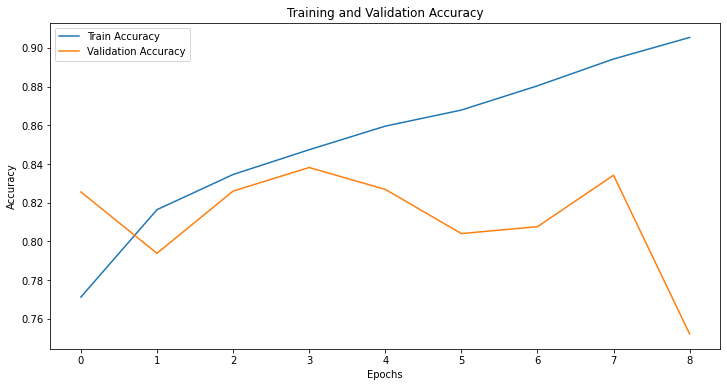

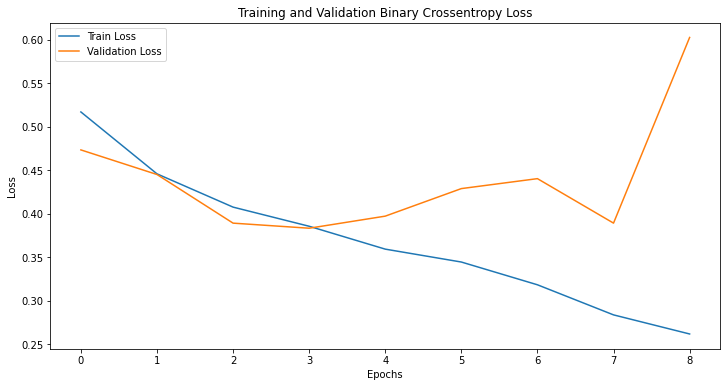

In [61]:
model_performance_plot(complex_cnn)